In [1]:
import pathlib
from pprint import pprint
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

The dataset referenced in this notebook consists of videos retrieved from YouTube involving human interactions, which were sliced into 10s segments. These segments were annotated by hand with a reward of `2` for strongly positive, `1` for slightly positive, `0` for neutral, `-1` for slightly negative, or `-2` for strongly negative. Segments and videos containing voice overlays, absent humans, etc. were filtered out.

Annotation instructions about what "postive" or "negative" means refer explicitly to whether a robot should be reward for causing the situation to occur. Therefore, for instance, heated debates could be marked as positive while displaying ostensibly negative emotions (such as apparent anger).

In [2]:
files = list(pathlib.Path('../results/').glob('**/*.csv'))
data = [pd.read_csv(file, index_col=0).drop(columns='timestamp_s').mean().to_dict() for file in files]
df = pd.DataFrame(data=data, index=list(files))
pprint(df.columns)
print(df.shape)

Index(['gt_reward', 'combined_reward', 'audio_reward', 'video_reward',
       'presence_reward', 'human_detected', 'audio_happy', 'audio_neutral',
       'audio_sad', 'audio_angry', 'audio_fearful', 'audio_disgusted',
       'audio_surprised', 'video_happy', 'video_neutral', 'video_sad',
       'video_angry', 'video_fearful', 'video_disgusted', 'video_surprised'],
      dtype='object')
(487, 20)


In [3]:
unique_source_videos = {re.match('(.*)_(\d+).csv', path.name).groups()[0] for path in df.index}
print(f'len(unique_source_videos)={len(unique_source_videos)}')

len(unique_source_videos)=75


In [4]:
# Drop d7Vqb2e... videos as these are Keanu Reeves and he is difficult to classify
df = df.drop(labels=[label for label in df.index if re.match('d7Vqb2e.*', str(label.name)) is not None])
print(df.shape)

(437, 20)


# Plot reward versus ground truth

In [5]:
dir_figures = pathlib.Path('figures')
dir_figures.mkdir(parents=True, exist_ok=True)

/home/tom/Documents/projects/social_robotics_reward/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


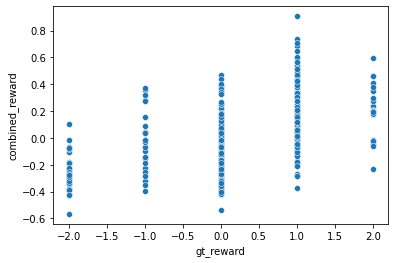

In [6]:
sns.scatterplot(df['gt_reward'], df['combined_reward'])
plt.savefig(str(dir_figures.joinpath('scatter_combined_reward')))

/home/tom/Documents/projects/social_robotics_reward/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


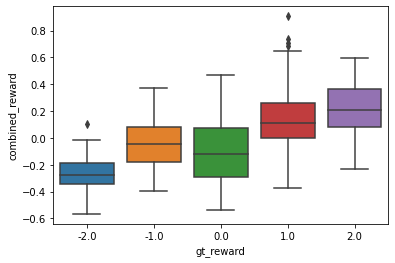

In [7]:
sns.boxplot(df['gt_reward'], df['combined_reward'])
plt.savefig(str(dir_figures.joinpath('box_combined_reward')))

In [41]:
descriptive_stats_gt = pd.concat([
    pd.DataFrame(data=[df['combined_reward'].describe().to_dict()], index=['overall']),
    pd.DataFrame(data=[df[df['gt_reward'] == gt]['combined_reward'].describe().to_dict() for gt in sorted(set(df['gt_reward']))], index=sorted(set(df['gt_reward']))),
]).round(3).rename(columns={'25%': '25th', '50%': '50th', '75%': '75th'})
print(descriptive_stats_gt)
descriptive_stats_gt.to_csv(str(dir_figures.joinpath('descriptive_stats_gt.csv')), header=True, index=True)

         count   mean    std    min   25th   50th   75th    max
overall  437.0  0.027  0.252 -0.567 -0.161  0.019  0.201  0.907
-2.0      29.0 -0.258  0.143 -0.567 -0.342 -0.275 -0.187  0.106
-1.0      26.0 -0.033  0.223 -0.396 -0.178 -0.046  0.079  0.371
0.0      158.0 -0.087  0.227 -0.538 -0.288 -0.119  0.071  0.466
1.0      205.0  0.145  0.210 -0.377  0.001  0.108  0.262  0.907
2.0       19.0  0.215  0.213 -0.232  0.082  0.206  0.362  0.596


/home/tom/Documents/projects/social_robotics_reward/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


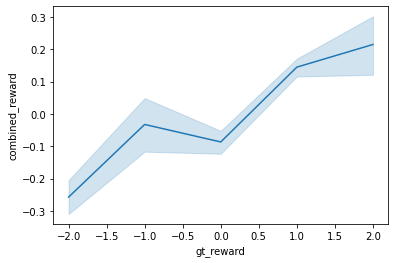

In [9]:
sns.lineplot(df['gt_reward'], df['combined_reward'])
plt.savefig(str(dir_figures.joinpath('line_combined_reward')))

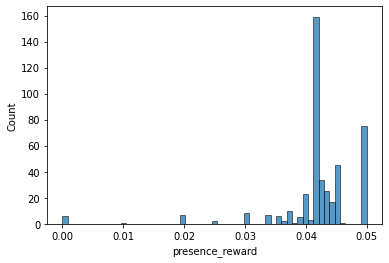

In [10]:
sns.histplot(df['presence_reward'])
plt.savefig(str(dir_figures.joinpath('hist_presence_reward')))

# Correlations with ground truth

In [40]:
print('Correlations with gt_reward:')
correlations_with_gt = df[['gt_reward', 'combined_reward', 'audio_reward', 'video_reward']].corr(method='pearson')['gt_reward'].round(3)
correlations_with_gt = correlations_with_gt.rename(index={label: re.sub('_', ' ', label) for label in correlations_with_gt.index})
correlations_with_gt = correlations_with_gt.rename(re.sub('_', ' ', correlations_with_gt.name))
print(correlations_with_gt)
correlations_with_gt.to_csv(str(dir_figures.joinpath('correlations_with_gt.csv')), header=True, index=True)

Correlations with gt_reward:
gt reward          1.000
combined reward    0.491
audio reward       0.142
video reward       0.486
Name: gt reward, dtype: float64


# Shapes of individual reward distributions:

In [42]:
descriptive_stats = df[['combined_reward', 'audio_reward', 'video_reward']].describe().round(3).transpose().rename(columns={'25%': '25th', '50%': '50th', '75%': '75th'})
descriptive_stats = descriptive_stats.rename(index={label: re.sub('_', ' ', label) for label in descriptive_stats.index})
print(descriptive_stats)
descriptive_stats.to_csv(str(dir_figures.joinpath('descriptive_stats.csv')), header=True, index=True)

                 count   mean    std    min   25th   50th   75th    max
combined reward  437.0  0.027  0.252 -0.567 -0.161  0.019  0.201  0.907
audio reward     437.0 -0.070  0.148 -0.394 -0.180 -0.137  0.013  0.362
video reward     437.0 -0.009  0.277 -0.678 -0.218 -0.006  0.173  0.969


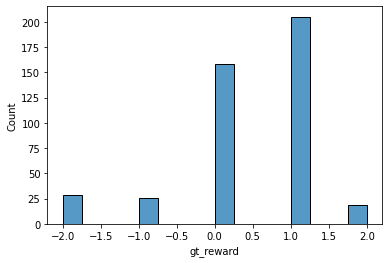

In [13]:
sns.histplot(df['gt_reward'])
plt.savefig(str(dir_figures.joinpath('hist_gt_reward')))

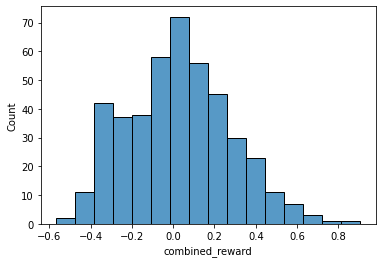

In [14]:
sns.histplot(df['combined_reward'])
plt.savefig(str(dir_figures.joinpath('hist_combined_reward')))

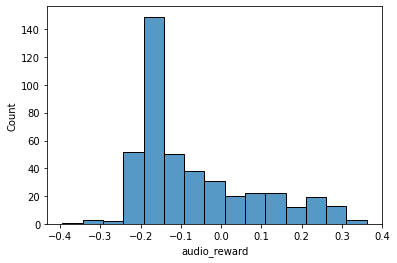

In [15]:
sns.histplot(df['audio_reward'])
plt.savefig(str(dir_figures.joinpath('hist_audio_reward')))

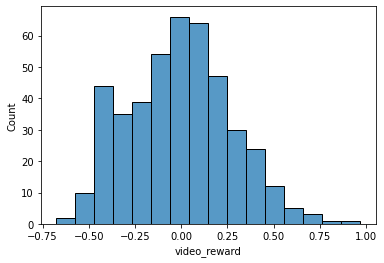

In [16]:
sns.histplot(df['video_reward'])
plt.savefig(str(dir_figures.joinpath('hist_video_reward')))

# Observe some of the "failures"

Assertive but emotionally netural (perhaps emotion = passionate?) cases are definitely poorly handled by this model. They tend to be predicted as angry/fearful, when ground truth is neutral. Probably sufficiently appropriate in a robotics situation (you don't want an opinionated argument with someone), but worth developing better expressiveness to separate unemotional neutral from passionate (but not angry/sad/...) in the future.

Future versions of the model should probably explicitly predict arousal in addition to valence (positive/negative) to account for this effect.

In [17]:
# 25th percentile:
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[int(len(df_0) * 0.25)]
# guy perhaps defensive or assertive in an argument about animal rights

gt_reward          0.000000
combined_reward   -0.290539
audio_reward      -0.178259
video_reward      -0.349311
presence_reward    0.041667
human_detected     0.833333
audio_happy        0.058738
audio_neutral      0.505917
audio_sad          0.227614
audio_angry        0.144580
audio_fearful      0.031455
audio_disgusted    0.023529
audio_surprised    0.008167
video_happy        0.003396
video_neutral      0.171270
video_sad          0.223186
video_angry        0.512231
video_fearful      0.016397
video_disgusted    0.050149
video_surprised    0.023371
Name: ../results/0_neutral/Eug1You8SH0_29.csv, dtype: float64

In [18]:
# 25th percentile (-1):
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[int(len(df_0) * 0.25)-1]
# incorrect; low quality video of rabbi talking at podium

gt_reward          0.000000
combined_reward   -0.295711
audio_reward      -0.196489
video_reward      -0.343773
presence_reward    0.033333
human_detected     0.666667
audio_happy        0.088858
audio_neutral      0.393525
audio_sad          0.299285
audio_angry        0.140120
audio_fearful      0.030752
audio_disgusted    0.039081
audio_surprised    0.008379
video_happy        0.041571
video_neutral      0.026909
video_sad          0.141497
video_angry        0.351208
video_fearful      0.345474
video_disgusted    0.008050
video_surprised    0.085291
Name: ../results/0_neutral/vnMYL8sF7bQ_12.csv, dtype: float64

In [19]:
# 25th percentile (-2):
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[int(len(df_0) * 0.25)-2]
# Chris D'Elia podcast; his delivery is quite aggressive and unsurprisingly is incorrect classified; incorrect nonetheless

gt_reward          0.000000
combined_reward   -0.296522
audio_reward      -0.199856
video_reward      -0.354882
presence_reward    0.042857
human_detected     0.857143
audio_happy        0.048135
audio_neutral      0.504784
audio_sad          0.229082
audio_angry        0.138003
audio_fearful      0.033527
audio_disgusted    0.036104
audio_surprised    0.010365
video_happy        0.001591
video_neutral      0.248062
video_sad          0.276541
video_angry        0.159103
video_fearful      0.069806
video_disgusted    0.166960
video_surprised    0.077937
Name: ../results/0_neutral/qoPSnFJxkrw_14.csv, dtype: float64

In [20]:
# 0th percentile:
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[0]
# "you can't have any respect for someone who acts like that" - incorrectly annotated

gt_reward          0.000000
combined_reward   -0.538076
audio_reward      -0.249538
video_reward      -0.620136
presence_reward    0.045000
human_detected     0.900000
audio_happy        0.105509
audio_neutral      0.227675
audio_sad          0.468901
audio_angry        0.132967
audio_fearful      0.019292
audio_disgusted    0.038432
audio_surprised    0.007223
video_happy        0.001623
video_neutral      0.015153
video_sad          0.021956
video_angry        0.520335
video_fearful      0.004414
video_disgusted    0.422242
video_surprised    0.014277
Name: ../results/0_neutral/xLrlCYS0Mao_21.csv, dtype: float64

In [21]:
# 0th percentile (+1):
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[1]
# Robert Gates neutral; definitely incorrect

gt_reward          0.000000
combined_reward   -0.419588
audio_reward      -0.177041
video_reward      -0.492834
presence_reward    0.041667
human_detected     0.833333
audio_happy        0.060005
audio_neutral      0.506227
audio_sad          0.218210
audio_angry        0.139307
audio_fearful      0.036965
audio_disgusted    0.027310
audio_surprised    0.011975
video_happy        0.001129
video_neutral      0.035157
video_sad          0.352747
video_angry        0.323859
video_fearful      0.202013
video_disgusted    0.063174
video_surprised    0.021920
Name: ../results/0_neutral/mz51C3Rx6DE_76.csv, dtype: float64

In [22]:
# 0th percentile (+2):
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[2]
# talking heads on news; man talking is netural, woman is displeased hence a difficult definition case

gt_reward          0.000000
combined_reward   -0.418751
audio_reward      -0.130278
video_reward      -0.500804
presence_reward    0.045000
human_detected     0.900000
audio_happy        0.092000
audio_neutral      0.503291
audio_sad          0.209382
audio_angry        0.120853
audio_fearful      0.043912
audio_disgusted    0.019020
audio_surprised    0.011543
video_happy        0.002428
video_neutral      0.034804
video_sad          0.026742
video_angry        0.584678
video_fearful      0.005813
video_disgusted    0.280081
video_surprised    0.065454
Name: ../results/0_neutral/xLrlCYS0Mao_22.csv, dtype: float64

In [23]:
# 0th percentile (+3):
df_0 = df[df['gt_reward'] == 0].sort_values(by='combined_reward', ascending=True)
df_0.iloc[3]
# opinionated man in podcast; not positive or negative but strong emotion; difficult definition case

gt_reward          0.000000
combined_reward   -0.402115
audio_reward      -0.181729
video_reward      -0.472899
presence_reward    0.041667
human_detected     0.833333
audio_happy        0.057076
audio_neutral      0.506579
audio_sad          0.233264
audio_angry        0.138165
audio_fearful      0.031470
audio_disgusted    0.025562
audio_surprised    0.007884
video_happy        0.003499
video_neutral      0.200190
video_sad          0.024797
video_angry        0.359886
video_fearful      0.040098
video_disgusted    0.349536
video_surprised    0.021995
Name: ../results/0_neutral/AAUjdjqUk_w_21.csv, dtype: float64